# **Library AND Load data**

In [3]:
from google.colab import drive
drive.mount('/content/Drive/')

Mounted at /content/Drive/


In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import files

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [6]:
# Chọn tệp JSON API Token từ máy tính của bạn
uploaded = files.upload()

# Di chuyển tệp JSON vào thư mục ~/.kaggle/
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
# Tải xuống bộ dữ liệu từ Kaggle
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Giải nén bộ dữ liệu
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# **Processing data**

In [8]:
# Danh sách các labels
labels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']

# Đường dẫn đến thư mục chứa dữ liệu
path = "/content/COVID-19_Radiography_Dataset"

# Kết hợp đường dẫn
data_dir = os.path.join(path)

# Khởi tạo danh sách data
data = []

# Duyệt qua từng label
for id, label in enumerate(labels):
    # Duyệt qua từng tệp tin trong thư mục của label hiện tại
    for file in os.listdir(os.path.join(data_dir, label + '/images')):
        # Thêm thông tin tệp tin và label vào danh sách data
        data.append(['{}/images/{}'.format(label, file), label])

# Giữ lại 2 cột: 'image_file' và 'result'
data = pd.DataFrame(data, columns=['image_file', 'result'])

# Tạo cột 'path' trong DataFrame data, kết hợp đường dẫn đầy đủ
data['path'] = path + '/' + data['image_file']

In [9]:
# Khởi tạo danh sách pixel_img để lưu trữ các ảnh
pixel_img = []

# Duyệt qua từng đường dẫn ảnh trong data
for image in tqdm(data['path']):
    # Mở ảnh và chuyển đổi sang ảnh đen trắng (grayscale)
    img = Image.open(image)
    img = ImageOps.grayscale(img)

    # Thay đổi kích thước ảnh thành 64x64 pixel
    img = img.resize((64, 64))

    # Chuyển đổi ảnh thành mảng numpy
    img = np.asarray(img)

    # Thay đổi hình dạng của ảnh để có kích thước (64, 64, 1)
    img = img.reshape((64, 64, 1))

    # Thêm ảnh vào danh sách pixel_img
    pixel_img.append(img)

# Chuyển đổi danh sách pixel_img thành mảng numpy
pixel_img = np.array(pixel_img)

# Tạo nhãn cho ảnh dựa trên label từ data
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity': 2, 'Viral Pneumonia': 3})

100%|██████████| 21165/21165 [00:50<00:00, 418.00it/s]


In [10]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_all, X_test_all, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

# Chuyển đổi nhãn thành dạng one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# MLP
# Tiền xử lý cho X_train
X_train = X_train_all.reshape(X_train_all.shape[0], -1)  # flatten image thành 1D vector
X_train = X_train.astype('float32') / 255.0

# Tiền xử lý cho X_test
X_test = X_test_all.reshape(X_test_all.shape[0], -1)  # flatten image thành 1D vector
X_test = X_test.astype('float32') / 255.0

input_size = X_train.shape[1]
num_classes = 4

In [11]:
def evaluate_model(model, X_test, y_test):
    # Dự đoán nhãn của tập kiểm tra
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Tính toán các thông số đánh giá
    accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
    report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    # In ra các thông số đánh giá
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)
    print("\nPrecision, Recall, F1-score:\n")
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average=None)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average=None)
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average=None)
    for i in range(len(labels)):
        print(labels[i])
        print("Precision:", precision[i])
        print("Recall:", recall[i])
        print("F1-score:", f1[i])
        print()

    # Tạo ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
def evaluate_aug_model(model, X_test, y_test):
    # Dự đoán nhãn cho dữ liệu kiểm tra
    y_pred = model.predict(X_test)

    # Chuyển đổi dự đoán về nhãn dạng số nguyên
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Tính toán các độ đo
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels, average='macro')
    recall = recall_score(y_test_labels, y_pred_labels, average='macro')

    # In ra các thông tin đánh giá
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print('\nClassification Report:')
    print(classification_report(y_test_labels, y_pred_labels))

    # Tính toán ma trận nhầm lẫn
    cm = confusion_matrix(y_test_labels, y_pred_labels)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# **3.4. Multilayer Perceptron (MLP)**

## Multilayer Perceptron (MLP)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [24]:
# MLP with ReLU and dropout
mlp_model = Sequential()
mlp_model.add(Dense(256, input_dim=input_size))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(num_classes))
mlp_model.add(Activation('softmax'))
mlp_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               1048832   
                                                                 
 activation_8 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
 activation_9 (Activation)   (None, 4)                 0         
                                                                 
Total params: 1,049,860
Trainable params: 1,049,860
Non-trainable params: 0
_________________________________________________________________


In [25]:
mlp_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
133/133 [==============================] - 2s 7ms/step - loss: 1.5189 - accuracy: 0.5162 - val_loss: 0.8792 - val_accuracy: 0.6352
Epoch 2/50
133/133 [==============================] - 1s 5ms/step - loss: 0.9303 - accuracy: 0.6026 - val_loss: 0.8500 - val_accuracy: 0.6355
Epoch 3/50
133/133 [==============================] - 1s 5ms/step - loss: 0.8845 - accuracy: 0.6194 - val_loss: 0.8211 - val_accuracy: 0.6567
Epoch 4/50
133/133 [==============================] - 1s 5ms/step - loss: 0.8578 - accuracy: 0.6347 - val_loss: 0.8078 - val_accuracy: 0.6652
Epoch 5/50
133/133 [==============================] - 1s 5ms/step - loss: 0.8444 - accuracy: 0.6428 - val_loss: 0.8369 - val_accuracy: 0.5970
Epoch 6/50
133/133 [==============================] - 1s 5ms/step - loss: 0.8237 - accuracy: 0.6513 - val_loss: 0.8427 - val_accuracy: 0.6660
Epoch 7/50
133/133 [==============================] - 1s 5ms/step - loss: 0.8162 - accuracy: 0.6586 - val_loss: 0.7715 - val_accuracy: 0.6863
Epoch 

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.7266713914481455

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.74      0.89      0.81      2038
          COVID       0.80      0.20      0.33       723
   Lung_Opacity       0.66      0.76      0.71      1203
Viral Pneumonia       0.90      0.70      0.79       269

       accuracy                           0.73      4233
      macro avg       0.78      0.64      0.66      4233
   weighted avg       0.74      0.73      0.70      4233


Precision, Recall, F1-score:

Normal
Precision: 0.7431604736627194
Recall: 0.8930323846908734
F1-score: 0.8112324492979718

COVID
Precision: 0.7956989247311828
Recall: 0.20470262793914246
F1-score: 0.3256325632563256

Lung_Opacity
Precision: 0.6616270698344132
Recall: 0.7639235245220283
F1-score: 0.7091049382716049

Viral Pneumonia
Precision: 0.9043062200956937
Recall: 0.7026022304832714
F1-score: 0.7907949790794979



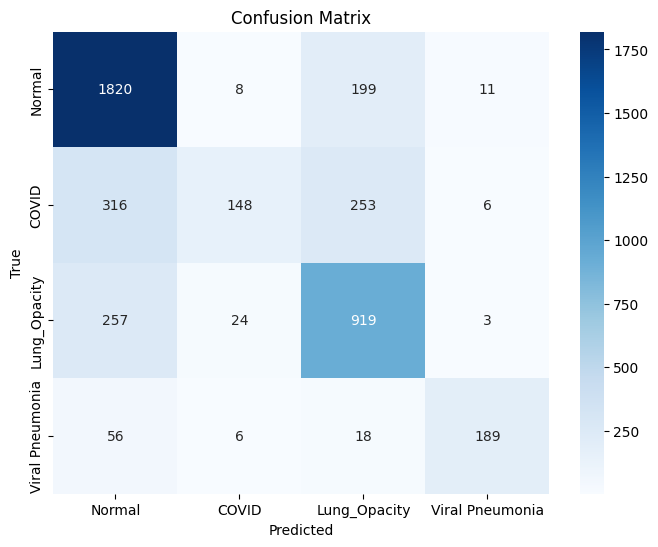

In [26]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(mlp_model, X_test, y_test)

In [27]:
# save
mlp_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/mlp_normal.h5")

## Multilayer Perceptron (MLP) - Oversampling

In [28]:
from imblearn.over_sampling import RandomOverSampler

In [29]:
# MLP with ReLU and dropout
mlp_model_Oversampling = Sequential()
mlp_model_Oversampling.add(Dense(256, input_dim=input_size))
mlp_model_Oversampling.add(Activation('relu'))
mlp_model_Oversampling.add(Dropout(0.5))
mlp_model_Oversampling.add(Dense(num_classes))
mlp_model_Oversampling.add(Activation('softmax'))
mlp_model_Oversampling.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               1048832   
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
 activation_11 (Activation)  (None, 4)                 0         
                                                                 
Total params: 1,049,860
Trainable params: 1,049,860
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_samples = np.bincount(np.argmax(y_train, axis=1))
max_samples = max(num_samples)
oversampling_ratio = 2
sampling_strategy = {label: int(count * oversampling_ratio) for label, count in enumerate(num_samples)}

over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train_oversampled, y_train_oversampled = over_sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (16308) in class 0 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (9618) in class 2 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(


In [31]:
mlp_model_Oversampling.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp_model_Oversampling.fit(X_train_oversampled, y_train_oversampled, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
265/265 [==============================] - 2s 6ms/step - loss: 1.3683 - accuracy: 0.5499 - val_loss: 0.8828 - val_accuracy: 0.6558
Epoch 2/50
265/265 [==============================] - 2s 7ms/step - loss: 0.8944 - accuracy: 0.6194 - val_loss: 0.8042 - val_accuracy: 0.6608
Epoch 3/50
265/265 [==============================] - 2s 6ms/step - loss: 0.8574 - accuracy: 0.6363 - val_loss: 0.7862 - val_accuracy: 0.6634
Epoch 4/50
265/265 [==============================] - 1s 5ms/step - loss: 0.8329 - accuracy: 0.6464 - val_loss: 0.7705 - val_accuracy: 0.6683
Epoch 5/50
265/265 [==============================] - 1s 4ms/step - loss: 0.8220 - accuracy: 0.6503 - val_loss: 0.7296 - val_accuracy: 0.7106
Epoch 6/50
265/265 [==============================] - 1s 4ms/step - loss: 0.8060 - accuracy: 0.6599 - val_loss: 0.7409 - val_accuracy: 0.7028
Epoch 7/50
265/265 [==============================] - 1s 4ms/step - loss: 0.7996 - accuracy: 0.6625 - val_loss: 0.7069 - val_accuracy: 0.7111
Epoch 

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.7642334042050555

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.82      0.86      0.84      2038
          COVID       0.63      0.53      0.58       723
   Lung_Opacity       0.73      0.71      0.72      1203
Viral Pneumonia       0.77      0.95      0.85       269

       accuracy                           0.76      4233
      macro avg       0.74      0.76      0.75      4233
   weighted avg       0.76      0.76      0.76      4233


Precision, Recall, F1-score:

Normal
Precision: 0.821563088512241
Recall: 0.8562315996074583
F1-score: 0.8385391638635271

COVID
Precision: 0.6317512274959084
Recall: 0.5338865836791148
F1-score: 0.5787106446776611

Lung_Opacity
Precision: 0.7275064267352185
Recall: 0.7057356608478803
F1-score: 0.7164556962025316

Viral Pneumonia
Precision: 0.770392749244713
Recall: 0.9479553903345725
F1-score: 0.85



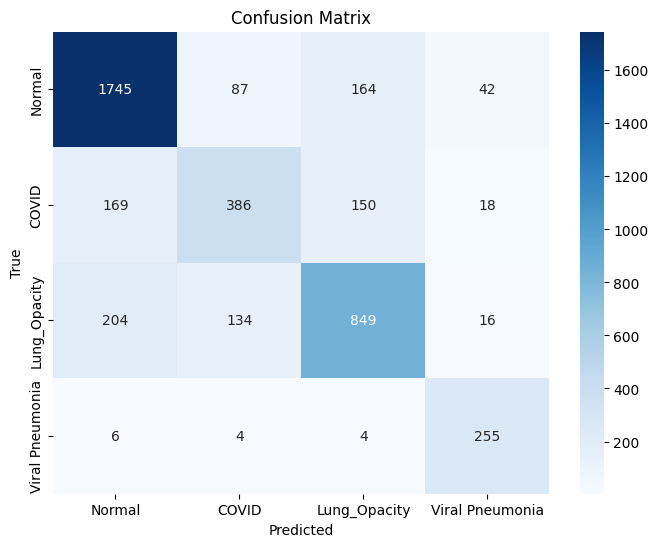

In [32]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(mlp_model_Oversampling, X_test, y_test)

In [33]:
# save
mlp_model_Oversampling.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/mlp_Oversampling.h5")

## Multilayer Perceptron (MLP) - Kết hợp Oversampling và Undersampling

In [34]:
from imblearn.combine import SMOTEENN

In [35]:
# MLP with ReLU and dropout
mlp_over_under_model = Sequential()
mlp_over_under_model.add(Dense(256, input_dim=input_size))
mlp_over_under_model.add(Activation('relu'))
mlp_over_under_model.add(Dropout(0.5))
mlp_over_under_model.add(Dense(num_classes))
mlp_over_under_model.add(Activation('softmax'))
mlp_over_under_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               1048832   
                                                                 
 activation_12 (Activation)  (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 1028      
                                                                 
 activation_13 (Activation)  (None, 4)                 0         
                                                                 
Total params: 1,049,860
Trainable params: 1,049,860
Non-trainable params: 0
_________________________________________________________________


In [36]:
sampler = SMOTEENN()
X_over_under_sampling, y_over_under_sampling = sampler.fit_resample(X_train, y_train)

In [37]:
mlp_over_under_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp_over_under_model.fit(X_over_under_sampling, y_over_under_sampling, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
200/200 [==============================] - 3s 9ms/step - loss: 1.2779 - accuracy: 0.6061 - val_loss: 1.3655 - val_accuracy: 0.4576
Epoch 2/50
200/200 [==============================] - 1s 6ms/step - loss: 0.7213 - accuracy: 0.7042 - val_loss: 1.1818 - val_accuracy: 0.5025
Epoch 3/50
200/200 [==============================] - 1s 5ms/step - loss: 0.6468 - accuracy: 0.7340 - val_loss: 1.2083 - val_accuracy: 0.5457
Epoch 4/50
200/200 [==============================] - 1s 5ms/step - loss: 0.6035 - accuracy: 0.7528 - val_loss: 1.2348 - val_accuracy: 0.5845
Epoch 5/50
200/200 [==============================] - 1s 4ms/step - loss: 0.5777 - accuracy: 0.7697 - val_loss: 1.3852 - val_accuracy: 0.5226
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.5530 - accuracy: 0.7807 - val_loss: 1.3470 - val_accuracy: 0.5837
Epoch 7/50
200/200 [==============================] - 1s 5ms/step - loss: 0.5370 - accuracy: 0.7885 - val_loss: 1.2365 - val_accuracy: 0.5979
Epoch 

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.6836758799905505

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.90      0.58      0.70      2038
          COVID       0.53      0.65      0.59       723
   Lung_Opacity       0.62      0.82      0.71      1203
Viral Pneumonia       0.58      0.96      0.72       269

       accuracy                           0.68      4233
      macro avg       0.66      0.75      0.68      4233
   weighted avg       0.74      0.68      0.69      4233


Precision, Recall, F1-score:

Normal
Precision: 0.8960244648318043
Recall: 0.5750736015701668
F1-score: 0.7005379557680813

COVID
Precision: 0.5338600451467269
Recall: 0.6542185338865837
F1-score: 0.5879428216283406

Lung_Opacity
Precision: 0.6217063989962359
Recall: 0.8237738985868661
F1-score: 0.7086163746871649

Viral Pneumonia
Precision: 0.5797752808988764
Recall: 0.9591078066914498
F1-score: 0.7226890756302521



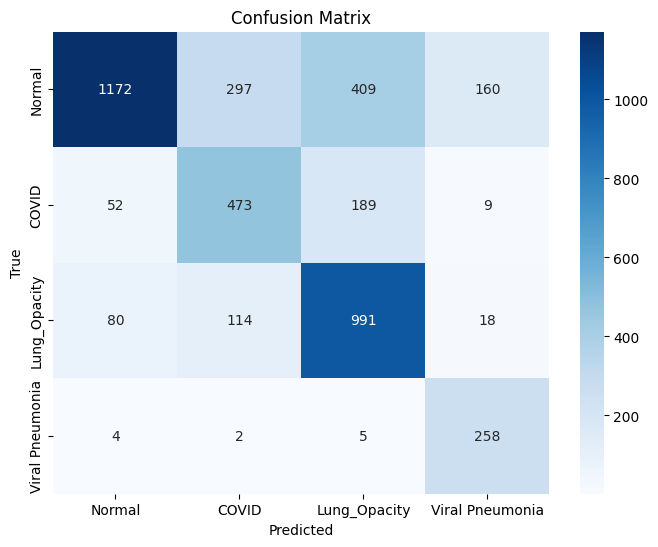

In [38]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(mlp_over_under_model, X_test, y_test)

In [39]:
# save
mlp_over_under_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/mlp_Over_Under.h5")

## Multilayer Perceptron (MLP) - Weighted Loss Function (sample weights)

In [40]:
from sklearn.utils import compute_sample_weight

In [41]:
# MLP with ReLU and dropout
mlp_sample_weight_model = Sequential()
mlp_sample_weight_model.add(Dense(256, input_dim=input_size))
mlp_sample_weight_model.add(Activation('relu'))
mlp_sample_weight_model.add(Dropout(0.5))
mlp_sample_weight_model.add(Dense(num_classes))
mlp_sample_weight_model.add(Activation('softmax'))
mlp_sample_weight_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               1048832   
                                                                 
 activation_14 (Activation)  (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 4)                 1028      
                                                                 
 activation_15 (Activation)  (None, 4)                 0         
                                                                 
Total params: 1,049,860
Trainable params: 1,049,860
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Tính toán trọng số mẫu
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [43]:
mlp_sample_weight_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp_sample_weight_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), sample_weight=sample_weights)

Epoch 1/50
133/133 [==============================] - 2s 7ms/step - loss: 0.9256 - accuracy: 0.3928 - val_loss: 1.0908 - val_accuracy: 0.5776
Epoch 2/50
133/133 [==============================] - 1s 5ms/step - loss: 0.6031 - accuracy: 0.4640 - val_loss: 0.9401 - val_accuracy: 0.6258
Epoch 3/50
133/133 [==============================] - 1s 5ms/step - loss: 0.5587 - accuracy: 0.5053 - val_loss: 0.9403 - val_accuracy: 0.6506
Epoch 4/50
133/133 [==============================] - 1s 5ms/step - loss: 0.5416 - accuracy: 0.5141 - val_loss: 1.2952 - val_accuracy: 0.4701
Epoch 5/50
133/133 [==============================] - 1s 5ms/step - loss: 0.5271 - accuracy: 0.5196 - val_loss: 1.0469 - val_accuracy: 0.5653
Epoch 6/50
133/133 [==============================] - 1s 6ms/step - loss: 0.5123 - accuracy: 0.5326 - val_loss: 1.1659 - val_accuracy: 0.5202
Epoch 7/50
133/133 [==============================] - 1s 7ms/step - loss: 0.5023 - accuracy: 0.5331 - val_loss: 0.9061 - val_accuracy: 0.6050
Epoch 

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.6784786203638081

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.89      0.60      0.72      2038
          COVID       0.42      0.78      0.55       723
   Lung_Opacity       0.73      0.69      0.71      1203
Viral Pneumonia       0.66      0.94      0.78       269

       accuracy                           0.68      4233
      macro avg       0.68      0.75      0.69      4233
   weighted avg       0.75      0.68      0.69      4233


Precision, Recall, F1-score:

Normal
Precision: 0.8922852983988355
Recall: 0.6015701668302257
F1-score: 0.7186400937866354

COVID
Precision: 0.42109199700822736
Recall: 0.7786998616874136
F1-score: 0.5466019417475728

Lung_Opacity
Precision: 0.7283085013146363
Recall: 0.6907730673316709
F1-score: 0.7090443686006827

Viral Pneumonia
Precision: 0.6614173228346457
Recall: 0.9368029739776952
F1-score: 0.7753846153846154



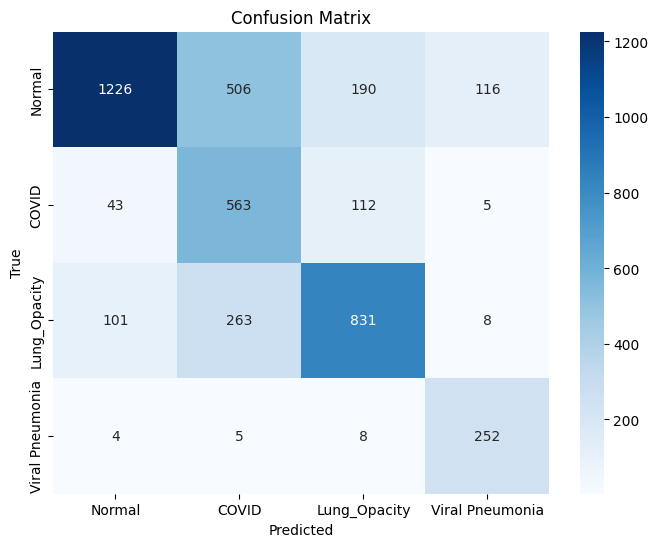

In [44]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(mlp_sample_weight_model, X_test, y_test)

In [45]:
# save
mlp_sample_weight_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/mlp_sample_weight.h5")

## Multilayer Perceptron (MLP) - Weighted Loss Function (class weights)

In [46]:
from sklearn.utils import compute_class_weight

In [47]:
# MLP with ReLU and dropout
mlp_class_weight_model = Sequential()
mlp_class_weight_model.add(Dense(256, input_dim=input_size))
mlp_class_weight_model.add(Activation('relu'))
mlp_class_weight_model.add(Dropout(0.5))
mlp_class_weight_model.add(Dense(num_classes))
mlp_class_weight_model.add(Activation('softmax'))
mlp_class_weight_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               1048832   
                                                                 
 activation_16 (Activation)  (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 4)                 1028      
                                                                 
 activation_17 (Activation)  (None, 4)                 0         
                                                                 
Total params: 1,049,860
Trainable params: 1,049,860
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Tính toán class weights dựa trên tần suất xuất hiện của từng lớp trong tập huấn luyện
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_img), y=label_img)
class_weights = dict(enumerate(class_weights))

In [49]:
mlp_class_weight_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp_class_weight_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/50
133/133 [==============================] - 2s 8ms/step - loss: 1.5127 - accuracy: 0.4337 - val_loss: 1.4292 - val_accuracy: 0.4328
Epoch 2/50
133/133 [==============================] - 1s 5ms/step - loss: 0.9540 - accuracy: 0.5357 - val_loss: 0.8200 - val_accuracy: 0.6449
Epoch 3/50
133/133 [==============================] - 1s 5ms/step - loss: 0.8914 - accuracy: 0.5727 - val_loss: 1.0137 - val_accuracy: 0.5934
Epoch 4/50
133/133 [==============================] - 1s 7ms/step - loss: 0.8649 - accuracy: 0.5822 - val_loss: 0.8542 - val_accuracy: 0.6244
Epoch 5/50
133/133 [==============================] - 1s 7ms/step - loss: 0.8372 - accuracy: 0.5885 - val_loss: 0.8647 - val_accuracy: 0.6031
Epoch 6/50
133/133 [==============================] - 1s 7ms/step - loss: 0.8241 - accuracy: 0.6032 - val_loss: 0.8135 - val_accuracy: 0.6513
Epoch 7/50
133/133 [==============================] - 1s 7ms/step - loss: 0.8159 - accuracy: 0.6039 - val_loss: 0.8096 - val_accuracy: 0.6598
Epoch 

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.748169147176943

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.85      0.79      0.82      2038
          COVID       0.55      0.64      0.59       723
   Lung_Opacity       0.70      0.73      0.71      1203
Viral Pneumonia       0.88      0.83      0.85       269

       accuracy                           0.75      4233
      macro avg       0.74      0.75      0.74      4233
   weighted avg       0.76      0.75      0.75      4233


Precision, Recall, F1-score:

Normal
Precision: 0.8512440444679725
Recall: 0.78900883218842
F1-score: 0.8189457601222306

COVID
Precision: 0.5517241379310345
Recall: 0.6417704011065007
F1-score: 0.5933503836317136

Lung_Opacity
Precision: 0.6984
Recall: 0.7256857855361596
F1-score: 0.7117814920505504

Viral Pneumonia
Precision: 0.8774703557312253
Recall: 0.8252788104089219
F1-score: 0.8505747126436781



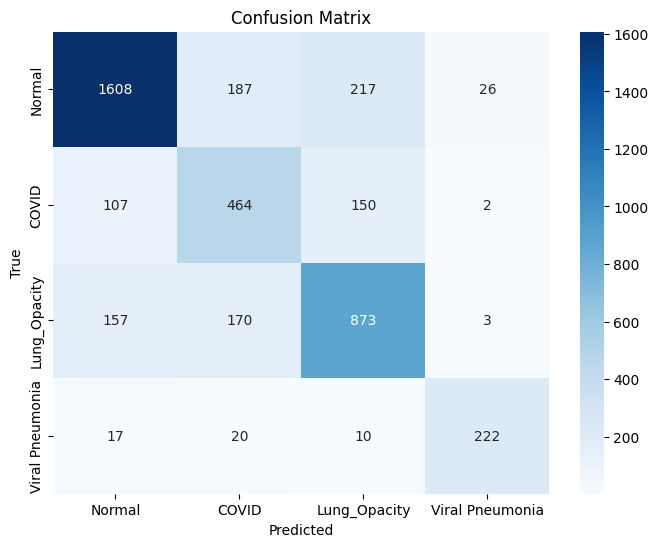

In [50]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(mlp_class_weight_model, X_test, y_test)

In [51]:
# save
mlp_class_weight_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/mlp_class_weight.h5")

## Multilayer Perceptron (MLP) - Data Augmentation

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten

In [53]:
# Tạo đối tượng ImageDataGenerator với các thuộc tính augmentation mong muốn
datagen = ImageDataGenerator(
    rotation_range=30,  # Góc xoay trong khoảng -30 đến 30 độ
    width_shift_range=0.1,  # Dịch chuyển theo chiều ngang trong khoảng -0.1 đến 0.1
    height_shift_range=0.1,  # Dịch chuyển theo chiều dọc trong khoảng -0.1 đến 0.1
    zoom_range=0.1,  # Tăng giảm tỷ lệ thu phóng trong khoảng 0.9 đến 1.1
    horizontal_flip=True,  # Lật ảnh theo chiều ngang (ngang dọc)
    vertical_flip=False,  # Không lật ảnh theo chiều dọc
    fill_mode='nearest'  # Sử dụng fill mode nearest
)

In [54]:
# MLP with ReLU and dropout
mlp_aug_model = Sequential()
mlp_aug_model.add(Flatten(input_shape=(64, 64, 1)))
mlp_aug_model.add(Dense(256))
mlp_aug_model.add(Activation('relu'))
mlp_aug_model.add(Dropout(0.5))
mlp_aug_model.add(Dense(4))
mlp_aug_model.add(Activation('softmax'))
mlp_aug_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               1048832   
                                                                 
 activation_18 (Activation)  (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 4)                 1028      
                                                                 
 activation_19 (Activation)  (None, 4)                 0         
                                                                 
Total params: 1,049,860
Trainable params: 1,049,860
N

In [55]:
# Sao chép X_train và X_test để giữ nguyên dữ liệu gốc
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()

# Tiền xử lý cho X_train_aug
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_train_aug = X_train_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Tiền xử lý cho X_test_aug
X_test_aug = X_test_aug.reshape(X_test_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_test_aug = X_test_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Chuẩn bị dữ liệu augmentation
datagen.fit(X_train_aug)

# Áp dụng augmentation cho X_train_aug để tạo X_aug_train
augmented_X_train = datagen.flow(X_train_aug, y_train, batch_size=128)

In [56]:
# Compile mô hình
mlp_aug_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với data augmentation
mlp_aug_model.fit(augmented_X_train, epochs=50, validation_data=(X_test_aug, y_test))

Epoch 1/50
133/133 [==============================] - 12s 85ms/step - loss: 1.2064 - accuracy: 0.4799 - val_loss: 1.1791 - val_accuracy: 0.4815
Epoch 2/50
133/133 [==============================] - 10s 76ms/step - loss: 1.1755 - accuracy: 0.4816 - val_loss: 1.1644 - val_accuracy: 0.4815
Epoch 3/50
133/133 [==============================] - 10s 75ms/step - loss: 1.1608 - accuracy: 0.4818 - val_loss: 1.1403 - val_accuracy: 0.4807
Epoch 4/50
133/133 [==============================] - 11s 83ms/step - loss: 1.1357 - accuracy: 0.4896 - val_loss: 1.1048 - val_accuracy: 0.4895
Epoch 5/50
133/133 [==============================] - 10s 79ms/step - loss: 1.1052 - accuracy: 0.5054 - val_loss: 1.0628 - val_accuracy: 0.5051
Epoch 6/50
133/133 [==============================] - 11s 83ms/step - loss: 1.0722 - accuracy: 0.5269 - val_loss: 1.0249 - val_accuracy: 0.5164
Epoch 7/50
133/133 [==============================] - 11s 82ms/step - loss: 1.0404 - accuracy: 0.5433 - val_loss: 0.9820 - val_accuracy:

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.655090952043468
Precision: 0.7084834942809114
Recall: 0.5188231125241256

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76      2038
           1       0.68      0.04      0.08       723
           2       0.68      0.59      0.63      1203
           3       0.84      0.51      0.64       269

    accuracy                           0.66      4233
   macro avg       0.71      0.52      0.53      4233
weighted avg       0.67      0.66      0.60      4233



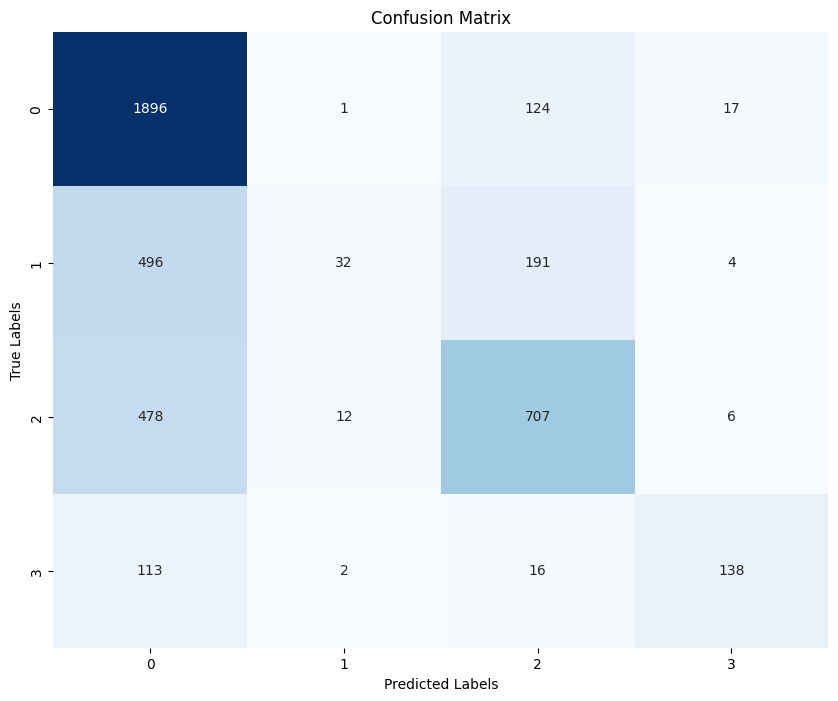

In [57]:
evaluate_aug_model(mlp_aug_model, X_test_aug, y_test)

In [58]:
# save
mlp_aug_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/mlp_augmentation.h5")

## Multilayer Perceptron (MLP) - Kết hợp Data Augmentation và Oversampling

In [59]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [60]:
# Tạo đối tượng ImageDataGenerator với các thuộc tính augmentation mong muốn
datagen = ImageDataGenerator(
    rotation_range=30,  # Góc xoay trong khoảng -30 đến 30 độ
    width_shift_range=0.1,  # Dịch chuyển theo chiều ngang trong khoảng -0.1 đến 0.1
    height_shift_range=0.1,  # Dịch chuyển theo chiều dọc trong khoảng -0.1 đến 0.1
    zoom_range=0.1,  # Tăng giảm tỷ lệ thu phóng trong khoảng 0.9 đến 1.1
    horizontal_flip=True,  # Lật ảnh theo chiều ngang (ngang dọc)
    vertical_flip=False,  # Không lật ảnh theo chiều dọc
    fill_mode='nearest'  # Sử dụng fill mode nearest
)

In [61]:
# MLP with ReLU and dropout
mlp_aug_over_model = Sequential()
mlp_aug_over_model.add(Flatten(input_shape=(64, 64, 1)))
mlp_aug_over_model.add(Dense(256))
mlp_aug_over_model.add(Activation('relu'))
mlp_aug_over_model.add(Dropout(0.5))
mlp_aug_over_model.add(Dense(4))
mlp_aug_over_model.add(Activation('softmax'))
mlp_aug_over_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               1048832   
                                                                 
 activation_20 (Activation)  (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 4)                 1028      
                                                                 
 activation_21 (Activation)  (None, 4)                 0         
                                                                 
Total params: 1,049,860
Trainable params: 1,049,860
N

In [62]:
# Sao chép X_train và X_test để giữ nguyên dữ liệu gốc
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()
# Chuẩn bị dữ liệu augmentation
datagen.fit(X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1))  # Thay đổi kích thước thành (samples, 64, 64, 1)

# Áp dụng augmentation cho X_train_aug để tạo X_aug_train
augmented_X_train = datagen.flow(X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1), y_train, batch_size=128)

# Chuyển đổi dữ liệu X_aug_train thành 2D
X_aug_train_2d = augmented_X_train[0][0].reshape(augmented_X_train[0][0].shape[0], -1)

# Áp dụng Oversampling trên dữ liệu tăng cường 2D
over_sampler = RandomOverSampler(sampling_strategy='auto')
X_aug_oversampling, y_aug_oversampling = over_sampler.fit_resample(X_aug_train_2d, augmented_X_train[0][1])

# Đưa dữ liệu X_aug_oversampling về 3D
X_aug_oversampling = X_aug_oversampling.reshape(X_aug_oversampling.shape[0], 64, 64, 1)

# Tiền xử lý cho X_train_aug
X_train_aug = X_aug_oversampling.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Tiền xử lý cho X_test_aug
X_test_aug = X_test_aug.reshape(X_test_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_test_aug = X_test_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Kết hợp dữ liệu tăng cường và dữ liệu oversampling
X_combined = np.concatenate((X_aug_oversampling, X_test_aug), axis=0)
y_combined = np.concatenate((y_aug_oversampling, y_test), axis=0)


In [63]:
# Compile mô hình
mlp_aug_over_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã được tăng cường và oversampling
mlp_aug_over_model.fit(X_combined, y_combined, epochs=50, validation_data=(X_test_aug, y_test))

Epoch 1/50
141/141 [==============================] - 2s 7ms/step - loss: 1.5211 - accuracy: 0.4611 - val_loss: 1.2070 - val_accuracy: 0.4815
Epoch 2/50
141/141 [==============================] - 1s 5ms/step - loss: 1.2781 - accuracy: 0.4732 - val_loss: 1.1740 - val_accuracy: 0.4815
Epoch 3/50
141/141 [==============================] - 1s 6ms/step - loss: 1.1858 - accuracy: 0.4783 - val_loss: 1.1609 - val_accuracy: 0.4815
Epoch 4/50
141/141 [==============================] - 1s 5ms/step - loss: 1.1633 - accuracy: 0.4823 - val_loss: 1.1444 - val_accuracy: 0.4815
Epoch 5/50
141/141 [==============================] - 1s 5ms/step - loss: 1.1370 - accuracy: 0.4830 - val_loss: 1.1190 - val_accuracy: 0.4815
Epoch 6/50
141/141 [==============================] - 1s 6ms/step - loss: 1.1089 - accuracy: 0.4850 - val_loss: 1.0927 - val_accuracy: 0.4807
Epoch 7/50
141/141 [==============================] - 1s 5ms/step - loss: 1.0859 - accuracy: 0.4885 - val_loss: 1.0554 - val_accuracy: 0.4902
Epoch 

In [64]:
import sklearn

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.7061185920151193
Precision: 0.7078189735403444
Recall: 0.6324620794285599

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      2038
           1       0.65      0.15      0.24       723
           2       0.64      0.75      0.69      1203
           3       0.80      0.76      0.78       269

    accuracy                           0.71      4233
   macro avg       0.71      0.63      0.63      4233
weighted avg       0.70      0.71      0.67      4233



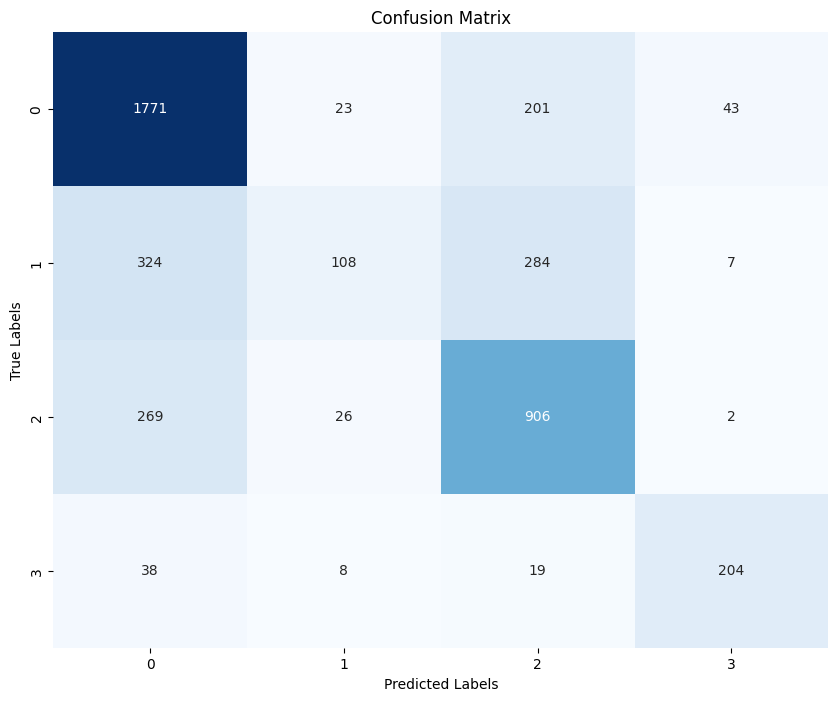

In [65]:
# Sử dụng hàm evaluate_aug_over_model để đánh giá mô hình đã huấn luyện
evaluate_aug_model(mlp_aug_over_model, X_test_aug, y_test)

In [66]:
# save
mlp_aug_over_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/mlp_aug_over.h5")